In [ ]:
Team Members: Sashi Gandavarapu & Raghu Pamidimarri

Questions:
    1. Why is knn better than Naive Bayes, LR, SVM? kNN works well with large sample size and fewer features. 
    2. How about NV, LR - Why do they not perform well? Even with GridSearch, they are not good. 
    3. Why is Random Forest the best here?
    4. Does any amount of tuning help other algorithms?
    5. Identify all the stuff that you can tune.
    
    
Kaggle board results:
1. Without any new features, RandomForest (estimators = 100, max_features = 9) => 0.735
2. Without any new features, ExtraRandomForest (estimators = 200, max_features = 9) => 0.736
3. With new features, ExtraRandomForest (estimators = 400, max_features = 9) => 0.739
4. PCA => 0.69 (PCA does not work)
5. Combined all soil features into a single soil feature (look at tweak_soil_features()) => 0.71578
 
 Things to try :
 a) Come up with new features + extra tress classifier => 0.7396
 b) PCA => 0.69. Tried PCA with different combinations (after adding more important features, with/without tuning, etc. does not give good values).
 c) Try tweaking more parameters of the RandomForestClassifier - explore the parameters it outputs.


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import savefig
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
#import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [160]:
#Read data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sampleSubmission = pd.read_csv("sampleSubmission.csv")

target = 'Cover_Type'

#shuffle train data
train = train.sample(frac=1.0)

print 'Shape of training data:', train.shape
print 'Shape of test data:', test.shape
print 'Frequency of target values:', train.Cover_Type.value_counts()
#NOTES: 
#1. The frequency of the labels in the training set is the same for all the labels! There is no imbalance in training
#2. The test set is very large as compared to the training set.


Shape of training data: (15120, 56)
Shape of test data: (565892, 55)
Frequency of target values: 7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64


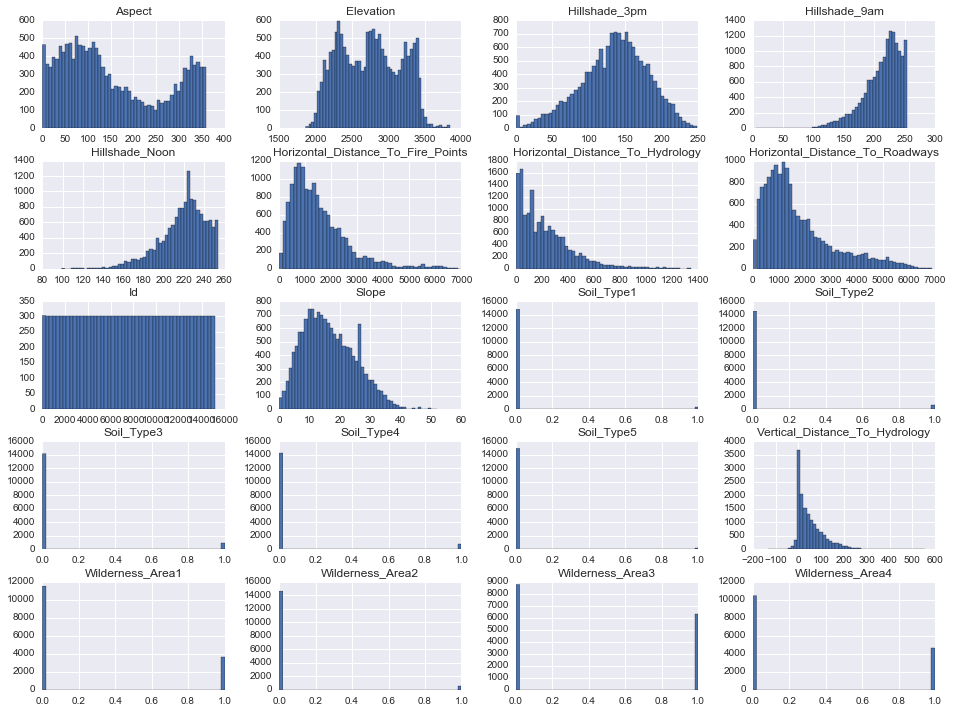

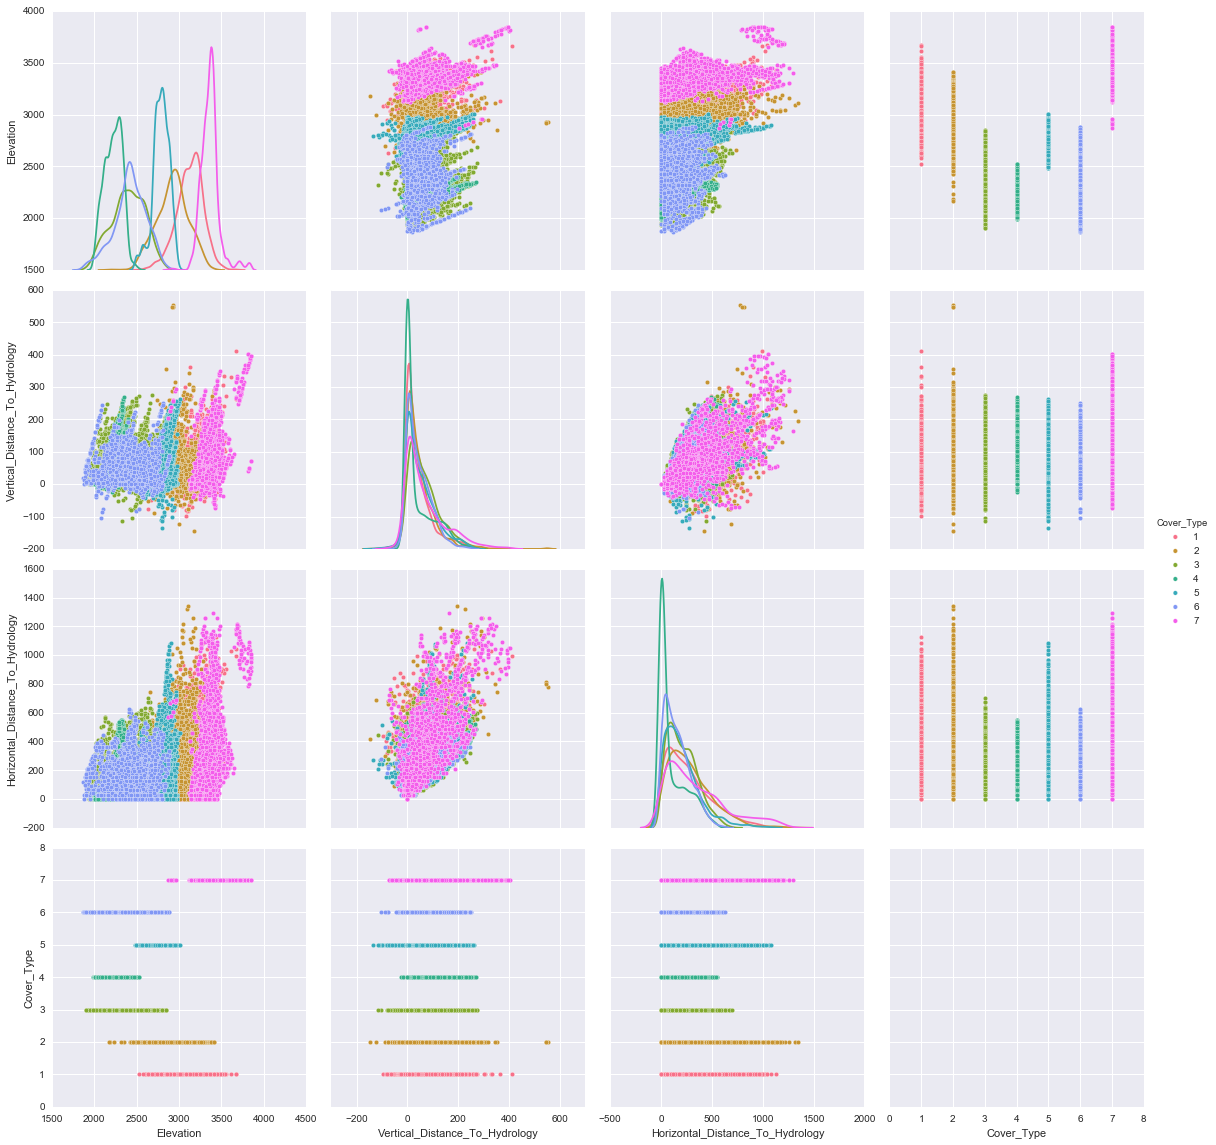

In [146]:
#Visualize the data
#Plot the histograms for the first 20 features (Which are all the numeric features and some binary features)
train.ix[:,:20].hist(figsize=(16,12),bins=50)
plt.show()

#Now, plot the relations between some interesting features
raw_features_to_plot = ['Elevation', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Cover_Type']
to_plot = train.ix[:, raw_features_to_plot]
sns.pairplot(to_plot, hue="Cover_Type", diag_kind="kde", size=4, aspect=1)

In [161]:
#Features Engineering

#Adding these features reduces the confusion between the class 1 and class 2 which (as you would notice further down) 
#are the most confused.
def addHydrologyFeatures():
    #Vertical_Distance_To_Hydrology could be either positive or negative and this is useful information to capture
    train['BelowHydrology'] = train.Vertical_Distance_To_Hydrology < 0
    test['BelowHydrology'] = test.Vertical_Distance_To_Hydrology < 0

    #How the elevation differs from the distance to hydrology is also useful
    train['DiffElevationVertDistToHydrology'] = train.Elevation-train.Vertical_Distance_To_Hydrology
    test['DiffElevationVertDistToHydrology'] = test.Elevation-test.Vertical_Distance_To_Hydrology

    train['DiffElevationHoriDistToHydrology'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
    test['DiffElevationHoriDistToHydrology'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

    #Euclidena distance
    train['Distance_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
    test['Distance_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

addHydrologyFeatures()

def addHigherPowerFeatures():
    train['squaredElevation'] = train['Elevation']**2
    test['squaredElevation'] = test['Elevation']**2

addHigherPowerFeatures()
    

def addHydroRoadFeatures():
    train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
    test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

    train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
    test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

    train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
    test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

    train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
    test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

    train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
    test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

    train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
    test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])
    
addHydroRoadFeatures()

#Make sure the angles are in the [0,180] range
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

def tweakAspect():
    train['Aspect2'] = train.Aspect.map(r)
    test['Aspect2'] = test.Aspect.map(r)
#NOTE: Do not tweak aspect - it does not help
#tweakAspect()

def tweakShades():
    train['Hillshade_9am'] = train['Hillshade_9am']/255
    test['Hillshade_9am'] = test['Hillshade_9am']/255

    train['Hillshade_Noon'] = train['Hillshade_Noon']/255
    test['Hillshade_Noon'] = test['Hillshade_Noon']/255

    train['Hillshade_3pm'] = train['Hillshade_3pm']/255
    test['Hillshade_3pm'] = test['Hillshade_3pm']/255

#NOTE: Do not tweak shades - it does not help
#tweakShades()

#There are 40 Soil type features, each of which is binary. Come up with a combination of all these features.
#NOTE: Do not know how turning this binary feature to an ordinal helps, but it does!
def tweakSoilFeatures():
    train['Soil']=0
    test['Soil']=0
    for i in range(1,41):
        train['Soil']=train['Soil']+i*train['Soil_Type'+str(i)]
        del train['Soil_Type'+str(i)]
        test['Soil']=test['Soil']+i*test['Soil_Type'+str(i)]
        del test['Soil_Type'+str(i)]
    
#tweakSoilFeatures()

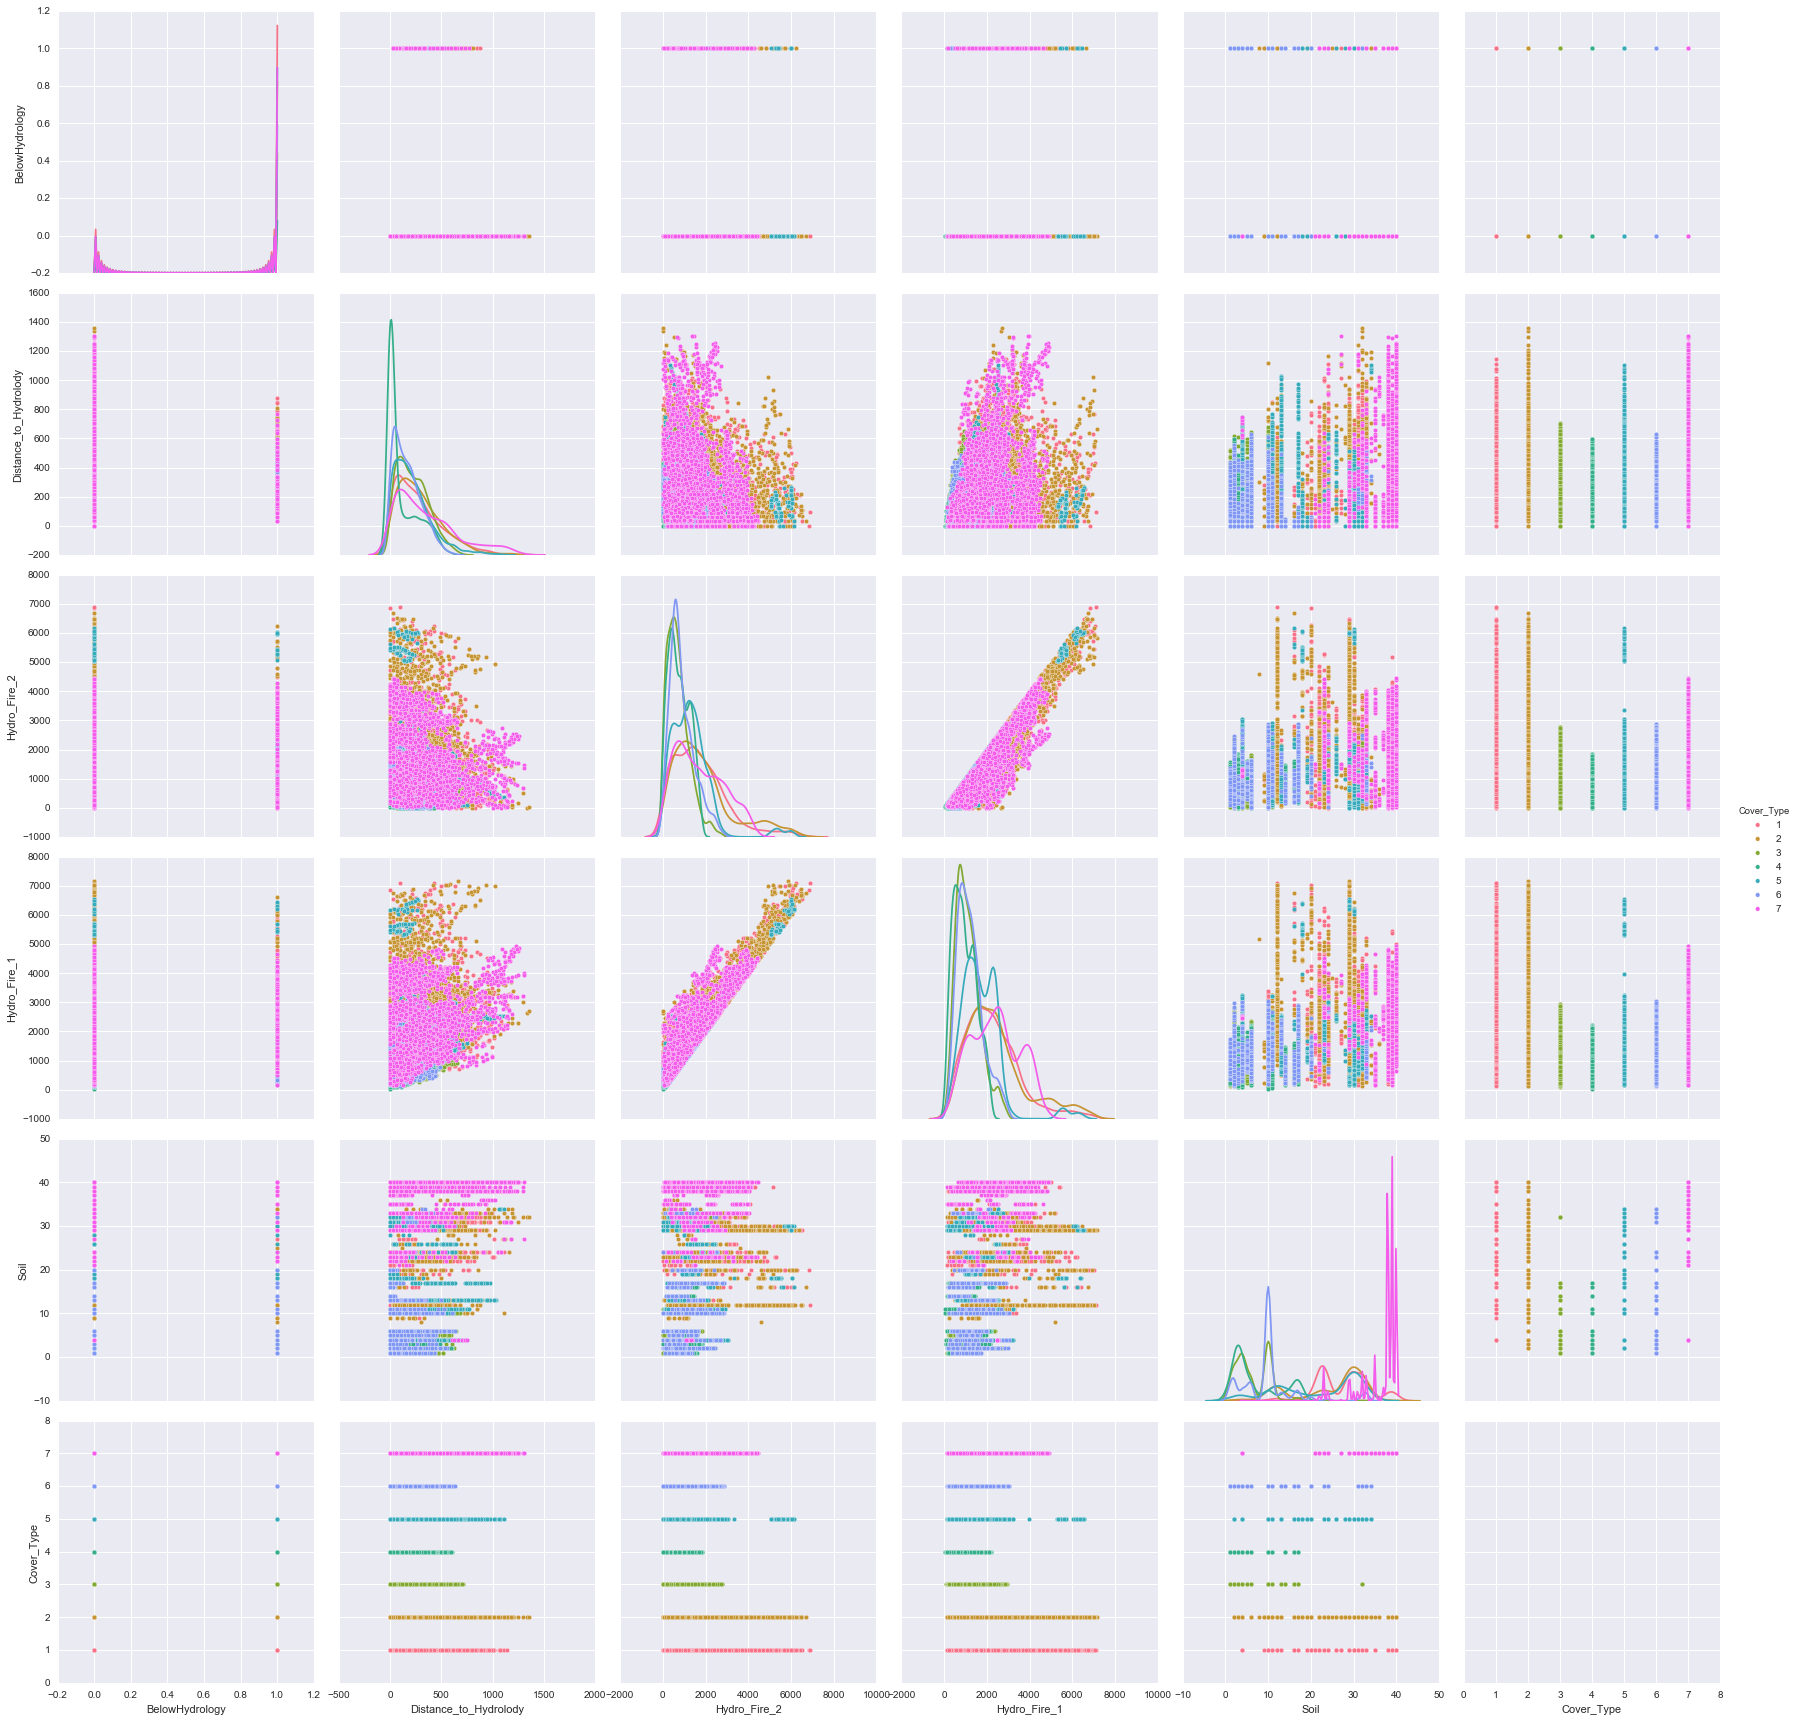

In [149]:
new_features_to_plot = ['BelowHydrology', 'Distance_to_Hydrolody', 'Hydro_Fire_2', 'Hydro_Fire_1', 'Soil', 'Cover_Type']
to_plot = train.ix[:, new_features_to_plot]
sns.pairplot(to_plot, hue="Cover_Type", diag_kind="kde", size=4, aspect=1)

In [162]:
IDcol = 'Id'
predictors = [x for x in train.columns if x not in [target, IDcol]]
print 'Number of features:',len(predictors)
print 'Features:', predictors

Number of features: 65
Features: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'BelowHydrology', 'DiffElevationVertDistToHydrology', 'DiffElevation

In [163]:
#Split into training and development dataset
X_fit, X_eval, y_fit, y_eval= train_test_split(train[predictors], train[target], test_size=0.1,random_state=10)

In [152]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X,Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    
    #Perform cross-validation:
    #Where is this cross validation used?
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, Y, cv=cv_folds, scoring='f1_weighted')
        print "CV (f1) Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g \n" % \
        (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy (Train): %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions)
    #print metrics.classification_report(Y.values, dtrain_predictions)
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, list(X_fit.columns.values)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')

In [ ]:
#1. Try knn
def knn():
    knn = KNeighborsClassifier()
    print "-------knn-------------"
    modelfit(knn, X_fit, y_fit,printFeatureImportance=False)
    preds = knn.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)

    #Try GridSearch for best k
    #NOTE: 1. Best value of k is actually 1 and NOT the default 5 => accuracy increases for kNN with grid search
    #with k=1, train accuracy is 1 and dev accuracy is 0.8047
    print "-------knn grid search-------"
    kValues = {'n_neighbors': [1,2,3,4,5,100]}
    clf = GridSearchCV(KNeighborsClassifier(), kValues)
    clf.fit(X_fit, y_fit)
    kValue = clf.best_params_['n_neighbors']
    print 'Best value for k for KNN:', kValue

    print "--------trying with tuned KNN----------"
    knn_best = KNeighborsClassifier(n_neighbors=kValue)
    modelfit(knn_best, X_fit, y_fit,printFeatureImportance=False)
    preds = knn_best.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
#NOTE: Uncomment the line below to run knn, if you want to. KNN is not a good model for this project.
#knn()

In [ ]:
#2. Try NB
def nb():
    bnb = BernoulliNB(binarize=0.5)
    print "-------NB-------------"
    modelfit(bnb, X_fit, y_fit,printFeatureImportance=False)
    preds = bnb.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)


    #NOTE: The best value of alpha is 0.00001 => smoothing has no impact on this. In fact, the default smoothing = 0 is better!
    alphas = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    clf = GridSearchCV(BernoulliNB(), alphas)
    clf.fit(X_fit, y_fit)
    best_alpha = clf.best_params_['alpha']
    print 'Best value for alpha:', best_alpha

    print "-------Trying tuned NB-------------"
    bnb = BernoulliNB(binarize=0.5, alpha=best_alpha)
    modelfit(bnb, X_fit, y_fit,printFeatureImportance=False)
    preds = bnb.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)

#NOTE: Uncomment the line below to run naive bayes, if you want to. Naive Bayes is not a good model for this project.
#NOTE: MULTINOMIAL NB does not work in this case - there are negative values
#nb()

In [ ]:
#3. Logistic regression
#With larger samples (15k samples with only 54 features), the low bias + high variance logistic regression works better than
#the high bias, low variance naive bayes.
def logistic():
    lgr = LogisticRegression()
    print "-------Logistic Regression-------------"
    modelfit(lgr, X_fit, y_fit,printFeatureImportance=False)
    preds = lgr.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
    cValues = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
    clf = GridSearchCV(LogisticRegression(), cValues)
    clf.fit(X_fit, y_fit)
    cValue = clf.best_params_['C'] 
    print 'Best value for C for Logistic Regression:', cValue

    lgr = LogisticRegression(C=cValue, penalty='l2')
    print "-------Logistic Regression with tuned parameters-------------"
    modelfit(lgr, X_fit, y_fit,performCV=False,printFeatureImportance=False)
    preds = lgr.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
    
#NOTE: Uncomment the line below to run Logistic Regression, if you want to. Logistic Regression is not a good model for this project.    
#logistic()

In [ ]:
#4. SVM
def svm():
    svm = SVC()
    print "-------SVM-------------"
    modelfit(svm, X_fit, y_fit,printFeatureImportance=False)
    preds = svm.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
    print "-------Find the best parameters for SVM-------------"
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
    #                     'C': [1, 10, 100, 1000]},
    #                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    #clf = GridSearchCV(SVC(), tuned_parameters)
    #clf.fit(X_fit, y_fit)
    #print clf.best_params_
    #The above returns {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
    print '---SVM with tuned parameters----------'
    svm_tuned = SVC(C=1000, gamma=0.001, kernel='rbf')
    modelfit(svm_tuned, X_fit, y_fit,performCV=False,printFeatureImportance=False)
    preds = svm_tuned.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
#NOTE: Uncomment the line below to run SVM, if you want to. SVM is not a good model for this project.                             
#svm()

CV (f1) Score : Mean - 0.8567317 | Std - 0.008299482 | Min - 0.8467457 | Max - 0.8662749 


Model Report
Accuracy (Train): 0.9959
Accuracy (Dev) : 0.8704
             precision    recall  f1-score   support

          1       0.83      0.82      0.83       246
          2       0.79      0.73      0.76       228
          3       0.88      0.80      0.84       230
          4       0.93      0.97      0.95       219
          5       0.89      0.93      0.91       204
          6       0.84      0.89      0.87       207
          7       0.94      0.98      0.96       178

avg / total       0.87      0.87      0.87      1512



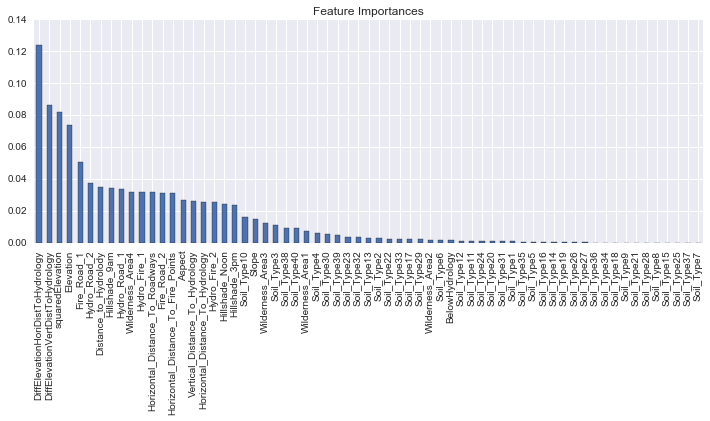

In [164]:
#let's try a simple Random Forest
def non_tuned_rfc():
    print 'Non-Tuned Random Forest'
    rfc = RandomForestClassifier(random_state=10)
    modelfit(rfc, X_fit, y_fit)
    #Evaluate on development data
    preds = rfc.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    print metrics.classification_report(y_eval.values, preds)
    
non_tuned_rfc()

In [170]:
def tune_rfc():
    #Let's try tuning random forest
    #Start with max_features= sq.rt(features) - http://scikit-learn.org/stable/modules/ensemble.html (1.11.2.3)
    print "-------Find the best parameters for RandomForest-------------"
    tune_params = {'n_estimators': [400,500,600], 'max_features':[8,9,10,11,12,13,14,15]}
    clf = GridSearchCV(RandomForestClassifier(), tune_params)
    clf.fit(X_fit, y_fit)
    print 'Best parametrs for RandomForest:', clf.best_params_

tune_rfc()


-------Find the best parameters for RandomForest-------------
Best parametrs for RandomForest: {'max_features': 8, 'n_estimators': 500}


In [165]:
#The output from above - Best parametrs for RandomForest: {'max_features': 8, 'n_estimators': 500}
print '--------Trying tuned RandomForest---------------'
trfc = RandomForestClassifier(max_features=8, n_estimators=500, min_samples_split=1, random_state=10, 
                            oob_score=True, bootstrap=True, max_depth=None)
modelfit(trfc, X_fit, y_fit, performCV=False, printFeatureImportance=True)
print 'oob score:', trfc.oob_score_
#Evaluate on development data
preds = trfc.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)
#print metrics.confusion_matrix(y_eval.values, preds)

RandomForest...

Model Report
Accuracy (Train): 1
oob score: 0.891166960611
Accuracy (Dev) : 0.8922
             precision    recall  f1-score   support

          1       0.85      0.83      0.84       246
          2       0.84      0.76      0.80       228
          3       0.92      0.83      0.88       230
          4       0.91      0.98      0.95       219
          5       0.91      0.98      0.94       204
          6       0.87      0.91      0.89       207
          7       0.95      0.99      0.97       178

avg / total       0.89      0.89      0.89      1512

[[205  29   0   0   4   0   8]
 [ 33 174   3   0  13   4   1]
 [  0   1 192  14   3  20   0]
 [  0   0   1 215   0   3   0]
 [  0   3   0   0 199   2   0]
 [  0   1  12   6   0 188   0]
 [  2   0   0   0   0   0 176]]
shape of pred_prob: (1512, 7)
[ 0.     0.004  0.286  0.166  0.     0.544  0.   ]


In [171]:
def tune_extra_trees():
    #Let's try tuning random forest
    #Start with max_features= sq.rt(features) - http://scikit-learn.org/stable/modules/ensemble.html (1.11.2.3)
    print "-------Find the best parameters for ExtraTrees-------------"
    tune_params = {'n_estimators': [800,1000,1200], 'max_features':[8,9,10,11,12]}
    clf = GridSearchCV(ExtraTreesClassifier(), tune_params)
    clf.fit(X_fit, y_fit)
    print 'Best parametrs for ExtaTrees:', clf.best_params_

tune_extra_trees()

-------Find the best parameters for RandomForest-------------
Best parametrs for RandomForest: {'max_features': 9, 'n_estimators': 1200}


Trying tuned ExtraTrees...

Model Report
Accuracy (Train): 1
oob score: 0.896310993533
F1 Score (Dev) : 0.8912
             precision    recall  f1-score   support

          1       0.85      0.82      0.83       246
          2       0.83      0.75      0.79       228
          3       0.93      0.86      0.90       230
          4       0.91      0.99      0.95       219
          5       0.90      0.97      0.94       204
          6       0.89      0.92      0.90       207
          7       0.94      0.98      0.96       178

avg / total       0.89      0.89      0.89      1512

[[202  29   0   0   5   0  10]
 [ 33 171   3   0  15   5   1]
 [  0   2 198  15   1  14   0]
 [  0   0   1 216   0   2   0]
 [  0   3   1   0 198   2   0]
 [  0   1   9   7   0 190   0]
 [  3   0   0   0   0   0 175]]


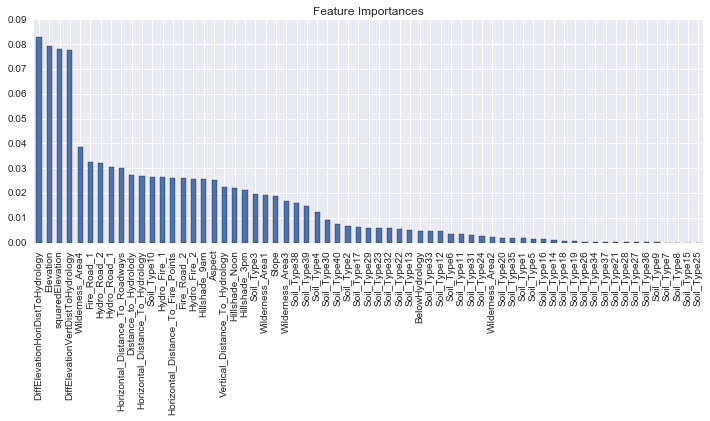

In [172]:
print 'Trying tuned ExtraTrees...'
etrfc = ExtraTreesClassifier(max_features=9, n_estimators=1200, oob_score=True, bootstrap=True, random_state=10)
modelfit(etrfc, X_fit, y_fit, performCV=False, printFeatureImportance=True)
print 'oob score:', etrfc.oob_score_
#Evaluate on development data
preds = etrfc.predict(X_eval)
print "F1 Score (Dev) : %.4g" % metrics.f1_score(y_eval.values, preds, average='weighted')
print metrics.classification_report(y_eval.values, preds)
print metrics.confusion_matrix(y_eval.values, preds)

The ExtraTrees model above is the best of all the models tried in this notebook. It gives a score of 0.7818 on the Kaggle Leader board (Rank = 343). The thing to note though is this:

This model gives an OOB Score (Out of bag score) of 0.89 - The out of bag score is a good measure to figure out how the model predicts unseen test data (Because that score captures how the samples were predicted by trees which did not have that sample). Even though the dev accuracy is around 0.89 and the OOB is 0.89, the leader board score is 0.78. The reason is that the test data is different from the training data. Training data has the equal number of all labels. Test data has predominantly 1 and 2 classes. And, if you notice the classification report and confusion matrix above, 1 and 2 classes do the worst in the dev data. That happens irrespective of any amount of tuning. That could be offset a bit by creating features which differentiate those 2 classes better. 


In [173]:
def find_confused_pairs():
    confusion = metrics.confusion_matrix(y_eval.values, preds)
    print 'confusion matrix:'
    print confusion
    confusion_transpose = np.transpose(confusion)
    confusion_sum = confusion + confusion_transpose
    #create a new matrix of the same shape as confusion_sum with ones.
    mask = np.ones(confusion_sum.shape, dtype=bool)
    #fill up the diagonal with 0, so that we dont count them in the max.
    np.fill_diagonal(mask, 0)
    #find the max
    max_value = confusion_sum[mask].max()
    print max_value
    #find the locations where the max is found - which is the pairs of digits most confused
    print np.where(confusion_sum == max_value)
find_confused_pairs()

confusion matrix:
[[202  29   0   0   5   0  10]
 [ 33 171   3   0  15   5   1]
 [  0   2 198  15   1  14   0]
 [  0   0   1 216   0   2   0]
 [  0   3   1   0 198   2   0]
 [  0   1   9   7   0 190   0]
 [  3   0   0   0   0   0 175]]
62
(array([0, 1]), array([1, 0]))


In [14]:
def test_rfc(features, weight, estimators):
    model = 'Number of features:'+ str(features) + ', Number of estimators:' + str(estimators) + ', Weight:' + weight
    print model
    trfc = RandomForestClassifier(max_features=features, n_estimators=estimators, min_samples_split=1, random_state=10, 
                            oob_score=True, bootstrap=True, max_depth=None, class_weight=weight)
    #trfc = ExtraTreesClassifier(max_features=7, n_estimators=500, min_samples_split=1, random_state=10, 
    #                            oob_score=True, bootstrap=True, max_depth=None)
    modelfit(trfc, X_fit, y_fit, performCV=False, printFeatureImportance=False)
    print 'oob score:', trfc.oob_score_
    #Evaluate on development data
    preds = trfc.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    
    print '--------------------------------------------------------'
    
def try_few_params_rfc():
    for features in range(6,9):
     for estimators in [400,500,600]:
        for weight in ['balanced', 'balanced_subsample']:
            test_rfc(features, weight, estimators)
            
#Test code to try different combinations of rfc and report accuracy and oob score
#try_few_params_rfc()

In [174]:
#Submission of test values -- Run this once after finalizing model
#preds = trfc.predict(test[predictors])
preds = etrfc.predict(test[predictors])
submission = pd.DataFrame({"Id":test[IDcol], "Cover_Type":preds})
submission.to_csv("submission_29.csv", index=False)

In [96]:
#Next Steps
    
#Tried few models learned so far in the class.
#Next steps include feature engineering to find more relevant features
#Also, to try other types of models, particularly neural networks. Continue tuning of the above models by performing gridsearch
#Currnet accuracy benchmark is 0.83 on dev data and 0.59 on public leaderboard